In [1]:
import utilities
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from pandas import read_csv
import multiprocessing as mp

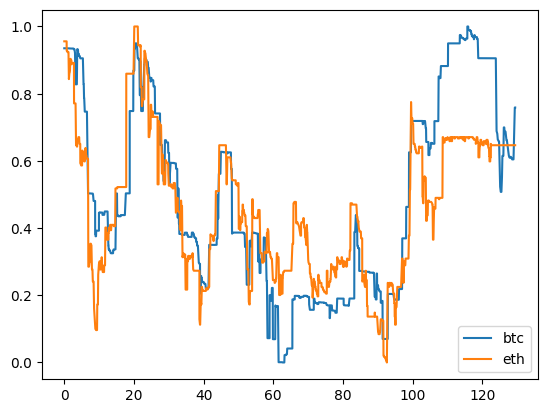

In [2]:
### PARAMETERS
products = ["btc", "eth"]
col_to_plot = "ask_price_min"
###

data_path = utilities.get_data_path(tree_level=2)
filenames = {}
dataframes = {}
scalers = {}

fig, ax = plt.subplots()

for product in products:
    filenames[product] = os.path.join(data_path, "datasets", f"{product}_stats_aligned.csv")
    dataframes[product] = pd.read_csv(filenames[product], index_col=0)

    # Normalize
    scalers[product] = MinMaxScaler()
    dataframes[product] = pd.DataFrame(scalers[product].fit_transform(dataframes[product]),
                                       columns=dataframes[product].columns,
                                       index=dataframes[product].index)
    
    time = dataframes[product].index
    ax.plot(time, dataframes[product][col_to_plot], label=product)

x1 = dataframes[products[0]]
x2 = dataframes[products[1]]

plt.legend()
plt.show()

In [3]:
values = pd.Series(dataframes["btc"][col_to_plot].values)
values

0       0.935095
1       0.935095
2       0.935095
3       0.935095
4       0.935095
          ...   
1995    0.604413
1996    0.604413
1997    0.604413
1998    0.758851
1999    0.758851
Length: 2000, dtype: float64

In [4]:
# See that that data is not stationary
result = adfuller(values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.923510
p-value: 0.321083


The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary. For our example, we fail to reject the null hypothesis.

Next we difference our time series and check the results of the ADF test. We will also look at the ACF.


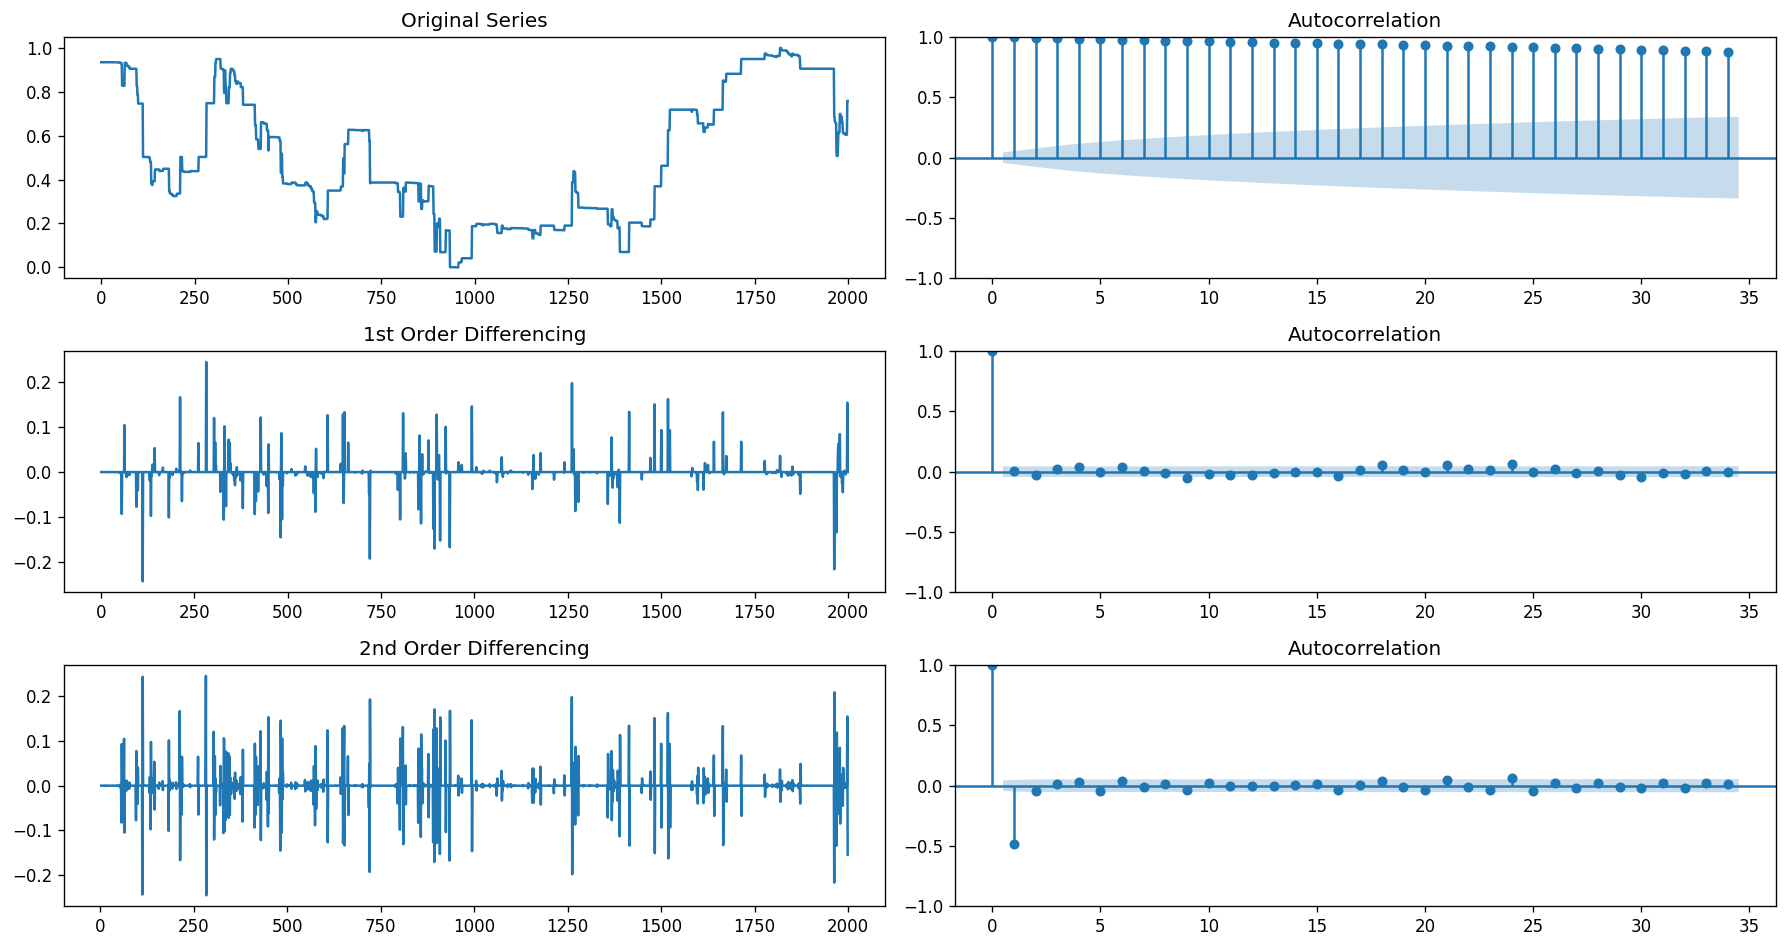

ADF Statistic for 1st Order Differencing
ADF Statistic: -44.487635
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568

 ADF Statistic for 2nd Order Differencing
ADF Statistic: -16.698079
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [5]:
plt.rcParams.update({'figure.figsize':(15,8), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(values); axes[0, 0].set_title('Original Series')
plot_acf(values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(values.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(values.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(values.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(values.diff().diff().dropna(), ax=axes[2, 1])

fig.tight_layout()
plt.show()

print('ADF Statistic for 1st Order Differencing')
result = adfuller(values.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('\n ADF Statistic for 2nd Order Differencing')
result = adfuller(values.diff().diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

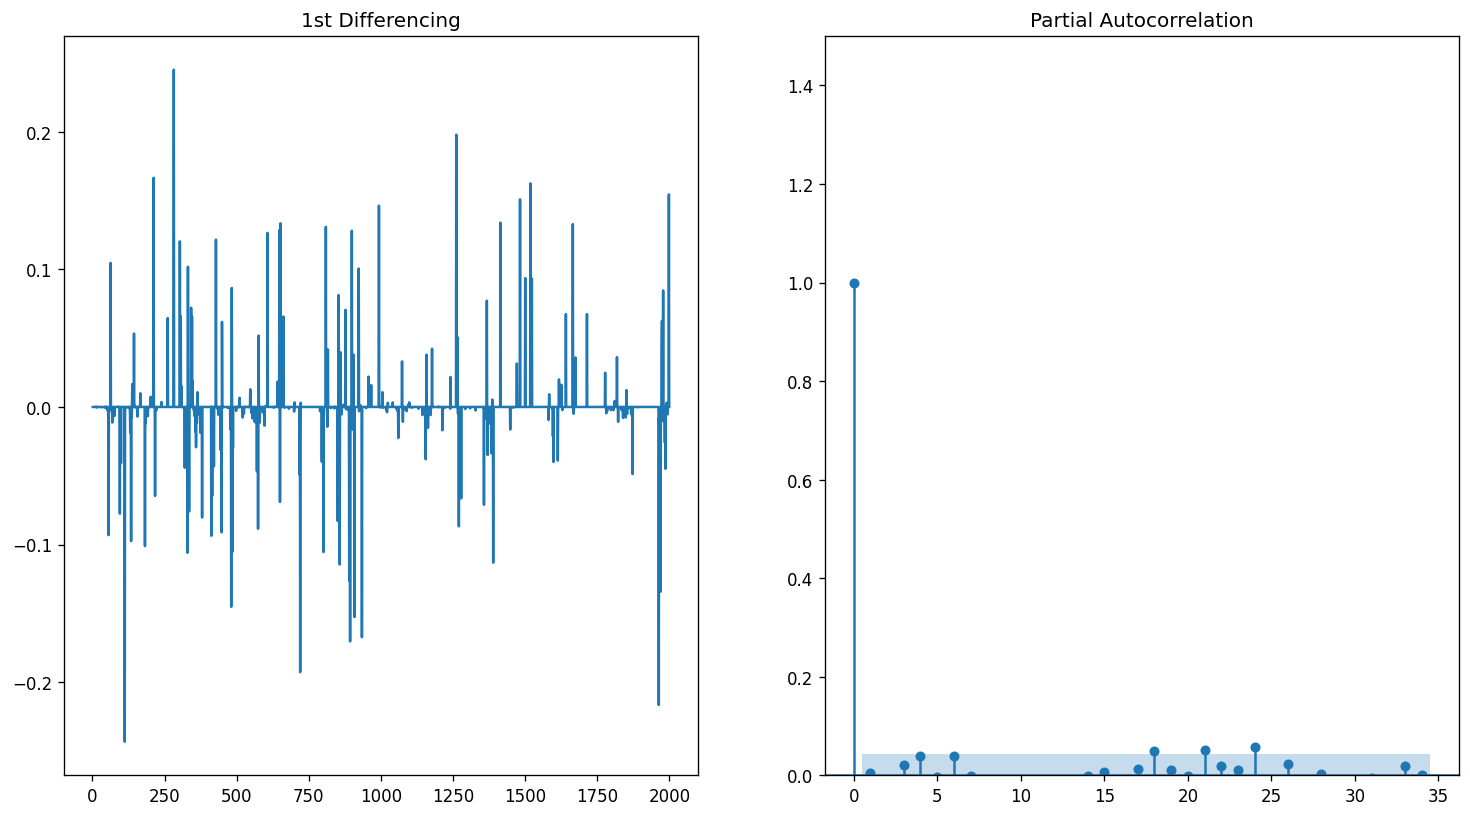

In [6]:
# AutoRegressive term p
# PACF plot of 1st differenced series
fig, axes = plt.subplots(1, 2)
axes[0].plot(values.diff())
axes[0].set_title('1st Differencing')

plot_pacf(values.diff().dropna(), ax=axes[1])
axes[1].set(ylim=(0,1.5))
plt.show()

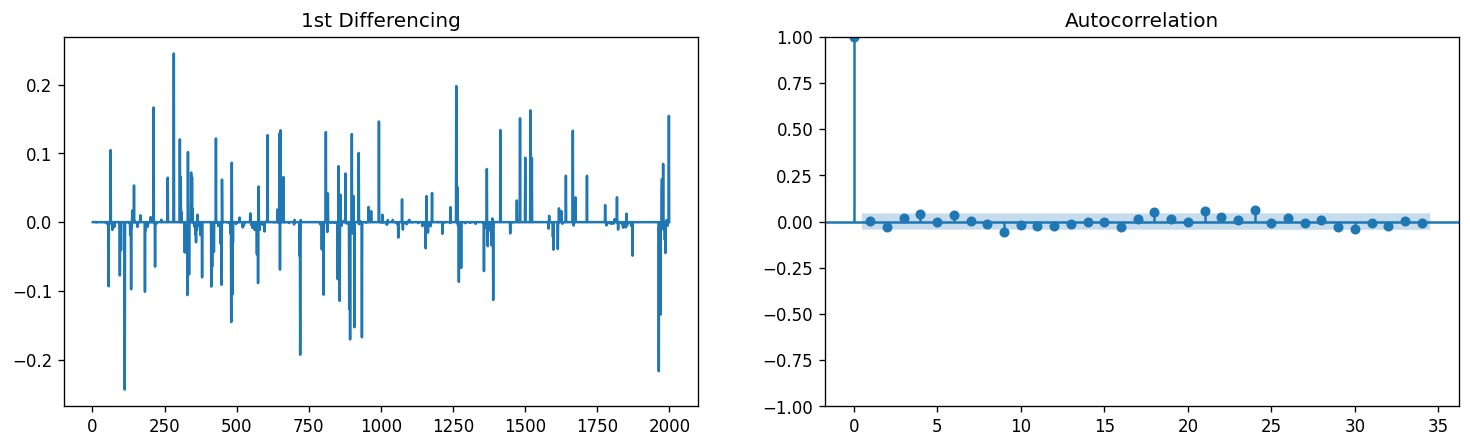

In [7]:
# Moving average term q
# ACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(15,4), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(values.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1))
plot_acf(values.diff().dropna(), ax=axes[1])

plt.show()

In [55]:
# order=(p,d,q)
# p: The number of lag observations (lag order) in the model (AR component).
# d: The number of times raw observations are differenced (degree of differencing).
# q: The size of the moving average window (order of the moving average).
model = ARIMA(values, order=(1,2,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2000
Model:                 ARIMA(1, 2, 0)   Log Likelihood                4332.737
Date:                Wed, 03 Apr 2024   AIC                          -8661.474
Time:                        23:52:38   BIC                          -8650.274
Sample:                             0   HQIC                         -8657.361
                               - 2000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4885      0.007    -71.885      0.000      -0.502      -0.475
sigma2         0.0008   7.17e-06    106.655      0.000       0.001       0.001
Ljung-Box (L1) (Q):                  60.80   Jarque-

W obrębie dyscypliny ekonometrii, fenomen heteroskedastyczności ujawnia się jako paradoks charakteryzujący się nieuniformną dyspersją residuów, co implikuje, że tradycyjne procedury estymacyjne, zakorzenione w założeniu homoskedastyczności, takie jak ortodoksyjna metoda najmniejszych kwadratów, mogą okazać się deficytarne. Nie inkorporują one bowiem potencjalnej heterogeniczności w zakresie dyspersji błędów losowych, co skutkuje imperatywem implementacji bardziej abstruzyjnych metod estymacyjnych. Przykładem są heteroskedastycznie konsystentne estymatory wariancji o charakterze uniwersalnym, które pozwalają na adekwatną korektę standardowych błędów, zapewniając tym samym bardziej wiarygodne wnioskowanie statystyczne.

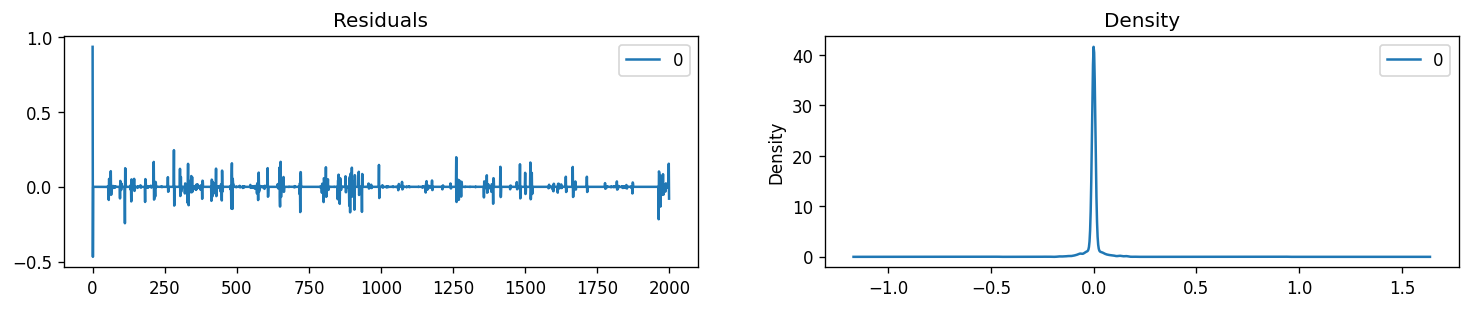

In [56]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15,2.5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

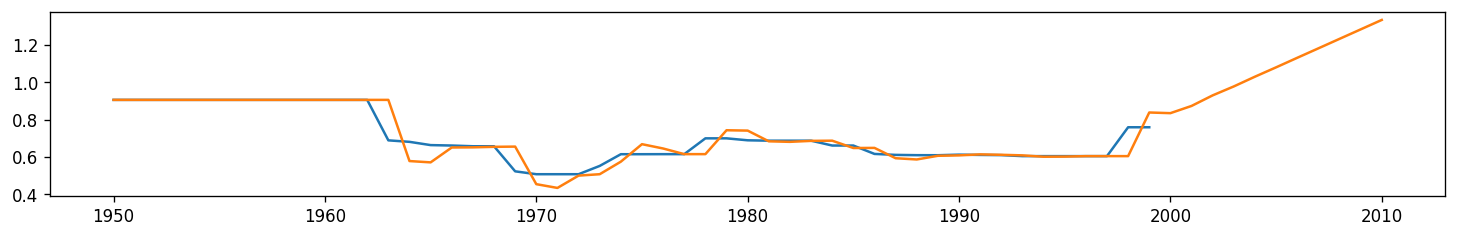

In [59]:
start = 900
stop = 1000
fig, ax = plt.subplots(figsize=(15,2))
ax = values[1950:].plot(ax=ax)
# fig = plot_predict(model_fit, 85, 100, dynamic=False, ax=ax, plot_insample=False)
# fig = plot_predict(model_fit, start+50, stop, dynamic=False, ax=ax)
pred = model_fit.get_prediction(start=1950, end=2010)
ax.plot(pred.predicted_mean)

plt.show()

In [30]:
model_fit.forecast(10)

2000    0.758851
2001    0.758851
2002    0.758851
2003    0.758851
2004    0.758851
2005    0.758851
2006    0.758851
2007    0.758851
2008    0.758851
2009    0.758851
Name: predicted_mean, dtype: float64

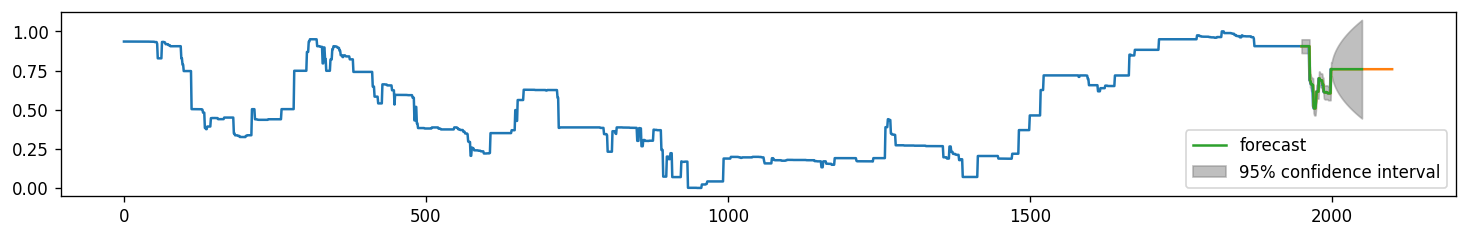

In [42]:
plot_predict(model_fit, 1950, 2050, ax=ax)

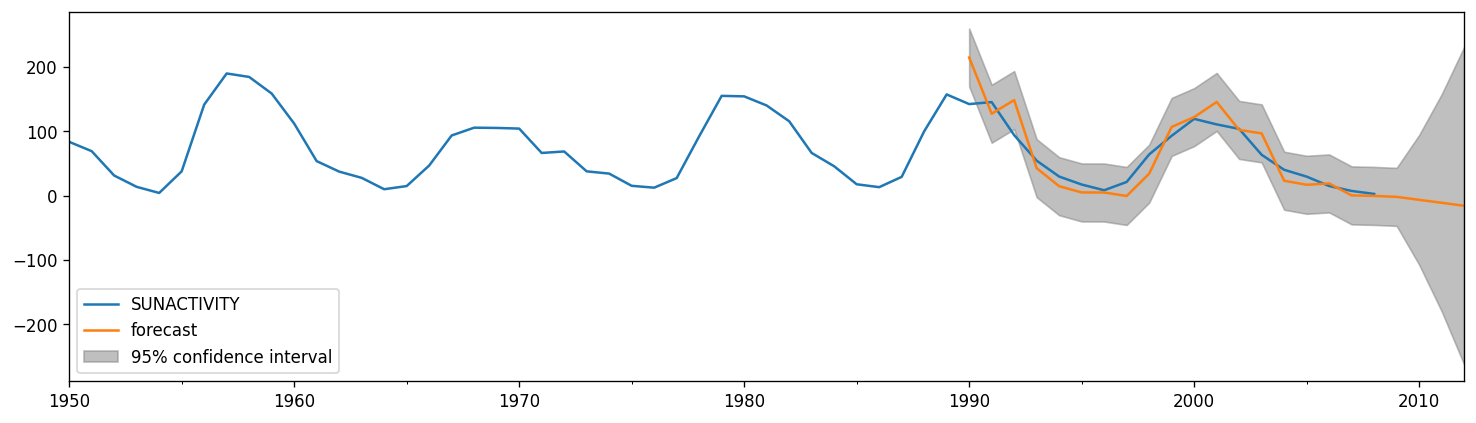

In [45]:
# EXAMPLE  !

import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA

dta = sm.datasets.sunspots.load_pandas().data[['SUNACTIVITY']]
dta.index = pd.date_range(start='1700', end='2009', freq='YE')
res = ARIMA(dta, order=(0,2,0)).fit()
fig, ax = plt.subplots()
ax = dta.loc['1950':].plot(ax=ax)
plot_predict(res, '1990', '2012', ax=ax)
plt.show()